# Tweet Sentiment Classification

This is intended to be an introductory exercise in binary sentiment classification of microblog data using deep learning. We'll be using the Stanford Sentiment140 dataset, which has been a testing benchmark for a multitude of academic papers largely due to its enourmous size. In fact, it's so big that I'm cutting down to a 10% sample for training, as it would otherwise take far too long to train on a personal machine. 

First things first, we load in and preprocess the data.

In [1]:
import pandas as pd

sent140_full = pd.read_csv("./datasets/sentiment140/traindata.csv", header = None)
sent140_test = pd.read_csv("./datasets/sentiment140/testdata.csv", header = None)

Let's take a look at what our dataset looks like and compute some summary statistics. Sentiment140 is actually broken into two clasifications: positive ("4") and negative ("0").

In [2]:
sent140_full.head(20)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
import numpy as np

print "Average Characters per Tweet:", np.average([len(tweet) for tweet in sent140_full[5].values])
print "Average Words per Tweet:", np.average([len(tweet.split(" ")) for tweet in sent140_full[5].values])
print "Label Distribution:"
print sent140_full[0].value_counts()

Average Characters per Tweet: 74.09011125
Average Words per Tweet: 14.382130625
Label Distribution:
4    800000
0    800000
Name: 0, dtype: int64


We have approximately 74 characters per tweet (including spaces), 14 words per tweet, and an equal number of positive and negative tweets. We next take a sample of the dataset for use in our neural network training.

In [4]:
sent140_train = sent140_full.sample(frac = 0.10)
sent140_test = sent140_test[sent140_test[0].isin([4,0])]

# Word Embeddings

A popular approach in natural language processing is using an embedded representation of words. By embedding words into n-dimensional vectors based on their co-occurence with other words in a corpus, we establish word-level similarities in the matrix that might not be captured in a sparser one-hot vocabulary representation. That is, words that appear in similar semantic circumstances should be embedded into similar vector representations and thus be closer in Euclidean space. We'll be using the Word2Vec library to build word embeddings for this corpus.

First, we build a vocabulary mapping for all the words contained within our tweet data.

In [5]:
from collections import Counter
import numpy as np
from gensim.models import Word2Vec

def build_vocab(sentences):
    vocab = Counter()
    lens = []
    for sentence in sentences:
        lens.append(len(sentence.split(" ")))
        for word in sentence.split(" "):
            if word != '':
                vocab[word.lower()] += 1

    #Summary Statistics
    print "Vocab Size:", len(vocab)
    print "Number of Words:", np.sum(vocab.values())
    print "Average Sentence Length:", np.average(lens)
    print "Top Twenty Most Common:"
    for word in vocab.most_common(20):
        print word
        
    mapping = dict(zip(vocab.keys(), np.arange(len(vocab))))
    return vocab, mapping

In [6]:
sent140s = sent140_train[5].values
sent140t = sent140_test[5].values
sent140_vocab, sent140_mapping = build_vocab(sent140_full[5].values)

Vocab Size: 1193538
Number of Words: 21080792
Average Sentence Length: 14.382130625
Top Twenty Most Common:
('i', 746583)
('to', 560313)
('the', 518728)
('a', 376421)
('my', 312846)
('and', 295670)
('you', 237766)
('is', 231085)
('for', 214050)
('in', 209958)
('it', 191050)
('of', 182598)
('on', 161592)
('so', 145769)
('have', 143295)
('that', 128774)
('me', 128489)
("i'm", 127616)
('but', 124673)
('just', 124453)


## Generating embedded representations of sentences

Here we generate the embedded vector representations of each sentence, using an "out-of-vocabulary" token for each word that appears less than 5 times in the corpus.

In [7]:
def preprocess_sents(sents, vocab, mincount):
    p_sents = []
    for sent in sents:
        processed = []
        for word in sent.split(" "):
            if vocab[word.lower().strip()] >= mincount:
                processed.append(word.lower())
            else:
                processed.append("oov")
        p_sents.append(processed)
        
    return p_sents

def generate_vectors(sentences, df_labels, mapping):
    vectors = []
    labels = []
    maximum = 0
    for sentence, label in zip(sentences, df_labels):
        if len(sentence) > 140:
            continue
        vector = [mapping[word.lower()] for word in sentence.split(" ")]
        vectors.append(vector)
        labels.append(label)
    return vectors, labels

def generate_embedv(sentences, vocab, embed):
    vectors = []
    oovcount = 0
    for sentence in sentences:
        vector = []
        for word in sentence:
            if word in embed:
                vector.append(embed[word])
            else:
                vector.append(embed["oov"])
                oovcount += 1
        vectors.append(np.array(vector))
    print oovcount
    return vectors
    

In [8]:
mincount = 5
embedding_size = 30

processed_train = preprocess_sents(sent140s, sent140_vocab, mincount)

In [9]:
embedding_train = Word2Vec(processed_train, size=embedding_size, min_count = mincount)
train_embeds = generate_embedv(processed_train, sent140_vocab, embedding_train)
processed_test = preprocess_sents(sent140t, sent140_vocab, mincount)
test_embeds = generate_embedv(processed_test, sent140_vocab, embedding_train)

/Users/Jay/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/Jay/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/Users/Jay/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


111167
406


# Learning a Neural Network

We'll be using Keras to create a simple neural network to learn on and classify our embedded sentence representations. 

In [10]:
import numpy as np
import os, errno
import pandas as pd
import sys
from keras.callbacks import EarlyStopping, Callback
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Flatten, Dropout, Conv1D, MaxPooling1D, SimpleRNN, GRU, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold

Using TensorFlow backend.


## Padding

Since neural networks generally have a fixed input size and our embedded sentences vary in length, we have to pad each sequence so that they are all the same size. We need to make sure that we can predict on our test data, so we pad our data with zeros to be the same size as the maximum length vector of either training or test data, whichever is larger.

In [11]:
max_train = np.max([len(arr) for arr in train_embeds])
max_test = np.max([len(arr) for arr in test_embeds])

max_len = max_train
if max_test > max_len:
    max_len = max_test

padded_train = pad_sequences(train_embeds, dtype = "float32", maxlen = max_len)
padded_test = pad_sequences(test_embeds, dtype = "float32", maxlen = max_len)

In [12]:
labels_train = sent140_train[0].map({4: 1, 0:0}).values
labels_test = sent140_test[0].map({4: 1, 0:0}).values

In [13]:
def shuffle_together(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def split_data(data, labels):
    shuffle_together(data, labels)
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2)
    return X_train, X_val, y_train, y_val


In [16]:
batch_size = 10000
optimizer = optimizers.Adam(lr = 0.02)
epochs = 50

class History(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

def train_model(layer_func, train_x, val_x, train_y, val_y, epochs):
    input_size = (train_x.shape[1], train_x.shape[2])
    model = layer_func(input_size)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    history = History()
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
    model.fit(train_x, train_y, validation_data = (val_x, val_y), shuffle = True, batch_size = batch_size, epochs = epochs, callbacks = [history, earlystop])
    return model, history

In [33]:
def cnn(input_size):
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 8,input_shape = (input_size)))
    model.add(MaxPooling1D(pool_size=4, padding='valid'))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters = 16, kernel_size = 4,input_shape = (input_size)))
    model.add(MaxPooling1D(pool_size=2, padding='valid'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation = "sigmoid"))
    return model

In [ ]:
np.random.seed(7)

scores = []
models = []
histories = []

for x in xrange(1, 11):
    X_train, X_val, y_train, y_val, = split_data(padded_train, labels_train)
    model, history = train_model(lstm, X_train, X_val, y_train, y_val, epochs)
    score = model.evaluate(padded_test, labels_test)
    models.append(model)
    histories.append(history)
    scores.append(score[1])
    print "Model Acc:%f" % (score[1]) 

Train on 128000 samples, validate on 32000 samples
Epoch 1/50
 80000/128000 [=================>............] - ETA: 68s - loss: 0.8864 - acc: 0.5052

In [21]:
avg_acc = np.average(scores)
avg_std = np.std(scores)

print "Average Accuracy: %f +/- %f" % (avg_acc, avg_std)



Average Accuracy: 0.665738 +/- 0.018477


In [71]:
import matplotlib.pyplot as plt

def plot_history(ys, names, title, ylabel):
    plt.clf()
    for y, name in zip(ys, names):
        x = np.arange(1, len(y) + 1)
        plt.plot(x, y, label = name)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel("Epoch")
    plt.legend()
    plt.savefig("./figures/"+title+".pdf")
    plt.show()

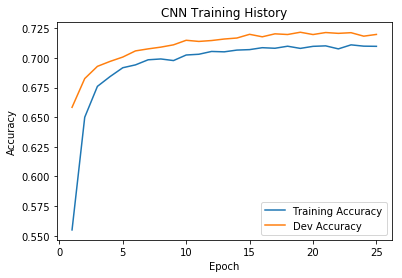

In [72]:
ys = [cnn_history.train_acc, cnn_history.val_acc]

plot_history(ys, ["Training Accuracy", "Dev Accuracy"], "CNN Training History", "Accuracy")

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_transformed = [np.concatenate(x) for x in padded_train]
X_test_transformed = [np.concatenate(x) for x in padded_test]

logR = LogisticRegression().fit(X_transformed, labels_train)
y_pred = logR.predict(X_test_transformed)
print accuracy_score(labels_test, y_pred)

0.66573816156


In [ ]:

def lstm(input_size):
    model = Sequential()
    model.add(LSTM(units = 64,input_shape = (input_size)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = "sigmoid"))
    return model